In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from sklearn import preprocessing, ensemble, metrics, linear_model, model_selection, inspection
import datetime as dt
from scipy import interpolate
from tqdm import tqdm
from pprint import pprint

# Functions need to be used

In [2]:
biome_name_list = ['Tropical forests', 'Temperate forests', 'Boreal forests', 'Tropical savannahs and grasslands', 'Temperate grasslands and shrublands', 'Deserts', 'Tundra', 'Croplands']

var_category_dict = {
    'Climate':       ['aridity', 'bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06', 'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18','bio19'],
    'Soil_physical': ['clay_0to30', 'sand_0to30', 'silt_0to30', 'clay_30to100', 'sand_30to100', 'silt_30to100'],
    'Soil_chemical': ['cec_0to30', 'nitrogen_0to30', 'ph_0to30', 'cec_30to100', 'nitrogen_30to100', 'ph_30to100'],
    'Topography':    ['elev', 'slp', 'cti', 'tri', 'vrm', 'roughness', 'tpi', 'spi']
}

color_category_dict = {
    'Climate':       '#0080FF',
    'Soil_physical': '#BA55D3', #'#FD7FFE'
    'Soil_chemical': '#FF7F02',
    'Topography':    '#00AA00'
}

x_names_topsoil = [
                   'elev', 'slp', 'cti', 'tri', 'vrm', 'roughness', 'tpi', 'spi',
                   'bio01', 'bio12',
                   'cec_0to30', 'clay_0to30', 'nitrogen_0to30', 'ph_0to30', 'sand_0to30', 'silt_0to30',
                  ]
x_names_subsoil = [
                   'elev', 'slp', 'cti', 'tri', 'vrm', 'roughness', 'tpi', 'spi',
                   'bio01', 'bio12',
                   'cec_30to100', 'clay_30to100', 'nitrogen_30to100', 'ph_30to100', 'sand_30to100', 'silt_30to100',
                  ]

In [3]:
def get_color_by_varname(var_name):
    color = 'black'
    for category in list(var_category_dict.keys()):
        if var_name in var_category_dict[category]:
            color = color_category_dict[category]
            break
    return color

def data_sampling(df, sample_size=100, group_name='biome_type_name', rand_seed=314):
    df_sampled = df.groupby(group_name, group_keys=False).apply(lambda x: x.sample(n=sample_size, random_state=rand_seed, replace=True)).reset_index(drop=True)
    # print(df_sampled.groupby('biome_type_name').agg({'profile_id': 'count'}).iloc[[5, 3, 0, 6, 4, 2, 7, 1]])
    return df_sampled

def data_sampling_by_weight(df, sample_size=100, weights_colname='sample_weight', rand_seed=314):
    df_sampled = df.sample(n=sample_size, weights=weights_colname, replace=True, random_state=rand_seed).reset_index(drop=True)
    # print(df_sampled.groupby('biome_type_name').agg({'profile_id': 'count'}).iloc[[5, 3, 0, 6, 4, 2, 7, 1]])
    return df_sampled

def get_category_importance(var_names, importances):
    df_category_importance = pd.DataFrame()
    category_list = []
    importance_list = []
    summary_list = []
    for category in list(var_category_dict.keys()):
        var_list = var_category_dict[category]
        importance_cate_list = []
        importance_category = 0.0
        for i in range(len(var_names)):
            if var_names[i] in var_list:
                importance_cate_list.append(importances[i])
        if len(importance_cate_list) > 0:
            # importance_category = np.mean(importance_cate_list)  # determing the category importance by using the mean of variable importances in each category
            importance_category = np.max(importance_cate_list)  # determing the category importance by using the max of variable importances in each category
            # importance_category = np.sum(importance_cate_list)  # determing the category importance by using the sum of variable importances in each category
            # importance_category = np.sum([v * v / np.sum(importance_cate_list) for v in importance_cate_list])  # determing the category importance by using the weighted averaged variable importances in each category (the weight is proportional to the importance)
        category_list.append(category)
        importance_list.append(importance_category)
    importance_list = [v / np.sum(importance_list) for v in importance_list]
    for i in range(len(list(var_category_dict.keys()))):
        category = list(var_category_dict.keys())[i]
        # summary_list.append('{} ({:.1f}%)'.format(category, importance_list[i]*100))
        summary_list.append('{:.1f}%'.format(importance_list[i]*100))
    df_category_importance['category'] = category_list
    df_category_importance['importance'] = importance_list
    df_category_importance['summary'] = summary_list
    return df_category_importance

def calc_feat_importance(x, y, model=None, method='permutation', cv=5, rand_seed=314):
    """
    method: 'normal' or 'permutation'
    """
    if model is None:
        model = ensemble.RandomForestRegressor(n_estimators=100, random_state=rand_seed)
    
    if method == 'normal':
        model.fit(x, y)
        # y_pred = model.predict(x)
        # r2 = metrics.r2_score(y, y_pred)
        # print('R2_score = {:.3f}'.format(r2))
        importances = model.feature_importances_
        sorted_id_list = np.argsort(importances)[::-1]
        sorted_x_names = [x_names[i] for i in sorted_id_list]
        sorted_importances = [np.round(importances[i], 3) for i in sorted_id_list]
    else:
        importances = []
        for cv_id in range(cv):
            x_train, x_val, y_train, y_val = model_selection.train_test_split(x, y, test_size=0.25, random_state=rand_seed)
            model.fit(x_train, y_train)
            r = inspection.permutation_importance(model, x_val, y_val, n_repeats=5, n_jobs=8, random_state=0)
            importances.append(list(r.importances_mean))
        importances = np.mean(importances, axis=0)
        sorted_id_list = np.argsort(importances)[::-1]
        sorted_x_names_ = [x_names[i] for i in sorted_id_list]
        sorted_importances_ = [np.round(importances[i], 3) for i in sorted_id_list]
        sorted_x_names = []
        sorted_importances = []
        for i in range(len(sorted_importances_)):
            if sorted_importances_[i] > 0:
                sorted_x_names.append(sorted_x_names_[i])
                sorted_importances.append(sorted_importances_[i])
    
    return sorted_x_names, sorted_importances

# Feature importance by RF

In [4]:
df = pd.read_csv('../datasets/processed/df_samples_with_covariates.csv')
print(df.shape)
print(list(df.columns))

(46237, 99)
['profile_id', 'country_id', 'country_name', 'latitude', 'longitude', 'SOCS_0to30', 'SOCS_30to100', 'biome', 'biome_type_0', 'biome_type_name_0', 'landcover', 'landcover_prop', 'biome_type', 'biome_type_name', 'npp_modis', 'rmf', 'agb', 'bgb', 'smp', 'fbgb', 'frbnpp_0to30', 'frbnpp_30to100', 'agb_unc', 'bgb_unc', 'frbnpp_0to30_sd', 'frbnpp_30to100_sd', 'frbnpp_0to30_unc', 'frbnpp_30to100_unc', 'bnpp', 'tovr_0to30', 'tovr_30to100', 'tovr_0to30_log', 'tovr_30to100_log', 'tovr_sub2top', 'fbgb_sd', 'tovr_0to30_sd', 'tovr_30to100_sd', 'clay_0to30', 'clay_30to100', 'sand_0to30', 'sand_30to100', 'silt_0to30', 'silt_30to100', 'nitrogen_0to30', 'nitrogen_30to100', 'ph_0to30', 'ph_30to100', 'cec_0to30', 'cec_30to100', 'bdod_pred_0to30', 'bdod_pred_30to100', 'cec_pred_0to30', 'cec_pred_30to100', 'cfvo_pred_0to30', 'cfvo_pred_30to100', 'clay_pred_0to30', 'clay_pred_30to100', 'nitrogen_pred_0to30', 'nitrogen_pred_30to100', 'ocd_pred_0to30', 'ocd_pred_30to100', 'phh2o_pred_0to30', 'phh2o

*** tovr_0to30_log ***
Global


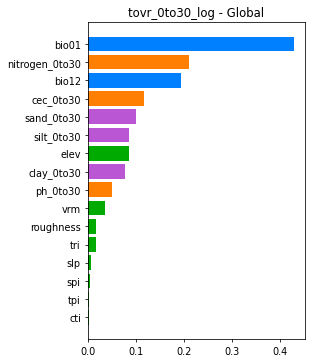

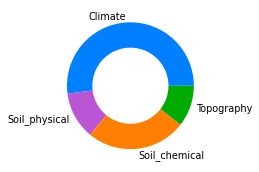


******

*** tovr_30to100_log ***
Global


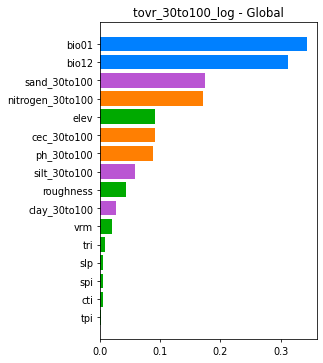

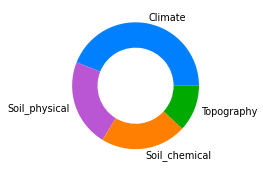


******



In [6]:
biome_type_name_list = ['Global']
# biome_name_list = ['Tropical forests', 'Temperate forests', 'Boreal forests', 'Tropical savannahs and grasslands', 'Temperate grasslands and shrublands', 'Deserts', 'Tundra', 'Croplands']
# biome_type_name_list = biome_name_list
y_names = ['tovr_0to30_log', 'tovr_30to100_log'] # 'tovr_sub2top'
sample_size = 1000
rand_seed = 314

for y_name in y_names:
    print('*** {} ***'.format(y_name))
    if '0to30' in y_name:
        x_names = x_names_topsoil
    else:
        x_names = x_names_subsoil
    for biome_type_name in biome_type_name_list:
        print(biome_type_name)
        if biome_type_name == 'Global':
            df_biome = df.reset_index(drop=True).copy()
        else:
            df_biome = df[df['biome_type_name'] == biome_type_name].reset_index(drop=True)
        df_biome = df_biome[[y_name] + x_names + ['biome_type_name']].dropna().reset_index(drop=True)
        
        # df_biome = data_sampling(df=df_biome, sample_size=sample_size, group_name='biome_type_name', rand_seed=314)
        
        x = np.array(df_biome[x_names])
        y = np.array(df_biome[y_name])
        # print(x.shape, y.shape)
        
        np.random.seed(rand_seed)
        model = ensemble.RandomForestRegressor(n_estimators=100, random_state=rand_seed)
        # sorted_x_names, sorted_importances = calc_feat_importance(x=x, y=y, model=model, method='normal', rand_seed=rand_seed)
        sorted_x_names, sorted_importances = calc_feat_importance(x=x, y=y, model=model, method='permutation', cv=5, rand_seed=rand_seed)
        
        df_res_feat_importance = pd.DataFrame()
        df_res_feat_importance['varname'] = sorted_x_names
        df_res_feat_importance['importance'] = sorted_importances
        # df_res_feat_importance.to_csv('./results/df_res_feat_importance_{}_{}.csv'.format(y_name, biome_type_name), index=False)
        
        plt.figure(figsize=(4, 6), dpi=70)
        colors = [get_color_by_varname(var_name=var_name) for var_name in sorted_x_names]
        plt.barh(sorted_x_names[::-1], sorted_importances[::-1], color=colors[::-1])
        plt.title('{} - {}'.format(y_name, biome_type_name))
        # plt.savefig('./figure/feature_importances_{}_{}.jpg'.format(y_name, biome_type_name), bbox_inches='tight', dpi=600)
        plt.show()
        
        df_category_importance = get_category_importance(var_names=sorted_x_names, importances=sorted_importances)
        plt.figure(figsize=(3, 3), dpi=70)
        # plt.pie(df_category_importance['importance'], labels=df_category_importance['summary'], normalize=True, wedgeprops={'width': 0.4}, colors=list(color_category_dict.values()))
        plt.pie(df_category_importance['importance'], labels=df_category_importance['category'], wedgeprops={'width': 0.4}, colors=list(color_category_dict.values()))
        # plt.savefig('./figure/category_importances_{}_{}.jpg'.format(y_name, biome_type_name), bbox_inches='tight', dpi=600)
        plt.show()
        print()
    print('******\n')